# **Initialization**

In [2]:
import os
import random
import shutil
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled and available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Please check runtime settings.")


GPU is enabled and available!
Device Name: Tesla T4


# **DenseNet121**

## **Import Libraries and Set Random Seeds**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Define Dataset Paths and Parameters**

In [ ]:
# Dataset paths
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

In [ ]:
# Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build and Compile the Model**

In [ ]:
# Load DenseNet-121 base model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 6,956,931 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

## **Set Up Model Checkpoints**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

## **Train the Model**

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7649 - auc: 0.8973 - loss: 0.6822 - precision: 0.7683 - recall: 0.7519
Epoch 1: val_loss improved from inf to 5.04970, saving model to best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 950s 6s/step - accuracy: 0.7656 - auc: 0.8977 - loss: 0.6803 - precision: 0.7689 - recall: 0.7526 - val_accuracy: 0.2933 - val_auc: 0.5217 - val_loss: 5.0497 - val_precision: 0.2933 - val_recall: 0.2933
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9149 - auc: 0.9806 - loss: 0.2579 - precision: 0.9179 - recall: 0.9122
Epoch 2: val_loss improved from 5.04970 to 0.34823, saving model to best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 619ms/step - accuracy: 0.9149 - auc: 0.9806 - loss: 0.2579 - precision: 0.9179 - recall: 0.9122 - val_accuracy: 0.9253 - val_auc: 0.9755 - val_loss: 0.3482 - val_precision: 0.9253 - val_recall: 0.9253
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9299 - auc: 0.9861 - loss

## **Plot Training History**

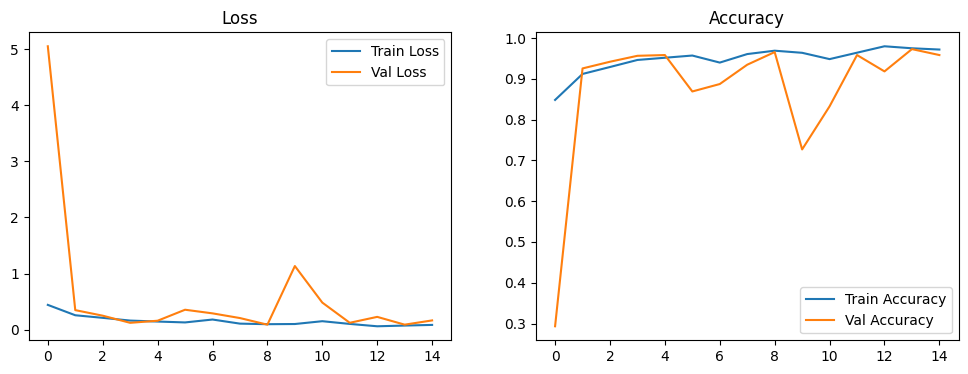

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [ ]:
# Evaluate on Test Data
model.load_weights('best_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 10s/step - accuracy: 0.9502 - auc: 0.9942 - loss: 0.1320 - precision: 0.9502 - recall: 0.9502
Test Loss: 0.0902
Test Accuracy: 0.9709
Test Precision: 0.9709
Test Recall: 0.9709
Test AUC: 0.9977


## **Generate Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.67      0.80         3
          RD       0.97      0.94      0.96        82
         ROP       0.97      0.99      0.98       190

    accuracy                           0.97       275
   macro avg       0.98      0.87      0.91       275
weighted avg       0.97      0.97      0.97       275


Confusion Matrix:
[[  2   0   1]
 [  0  77   5]
 [  0   2 188]]


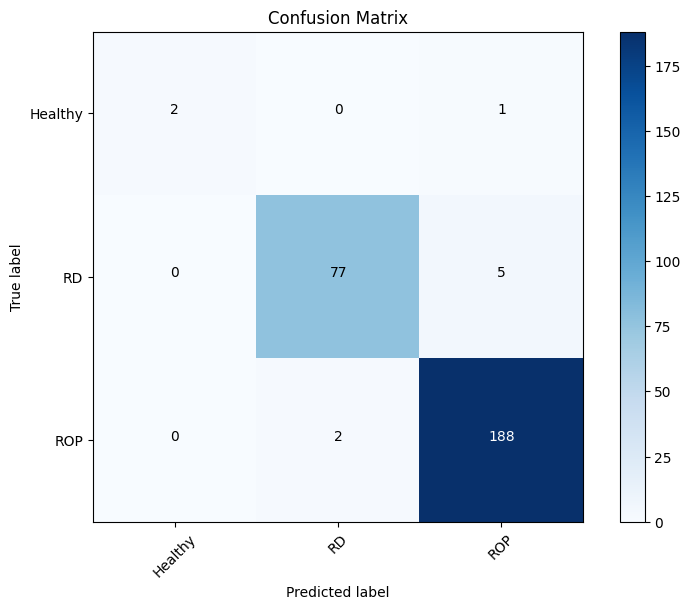

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'densenet_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

# **EfficientNetB0**

## **Imports and Setup**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Dataset Paths and Parameters**

In [ ]:
# Path to dataset folders
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augumentation and Preprocessing**

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Model Building**

In [ ]:
# Build the Model
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes as per your dataset (e.g., 3 for Healthy, ROP, RD)
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Training**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_rop_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.6822 - auc: 0.8434 - loss: 0.7346 - precision: 0.7612 - recall: 0.5414
Epoch 1: val_loss improved from inf to 1.56858, saving model to best_rop_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 203s 991ms/step - accuracy: 0.6831 - auc: 0.8441 - loss: 0.7329 - precision: 0.7618 - recall: 0.5429 - val_accuracy: 0.2878 - val_auc: 0.2875 - val_loss: 1.5686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8981 - auc: 0.9762 - loss: 0.2867 - precision: 0.9059 - recall: 0.8923
Epoch 2: val_loss did not improve from 1.56858
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 574ms/step - accuracy: 0.8981 - auc: 0.9763 - loss: 0.2865 - precision: 0.9059 - recall: 0.8924 - val_accuracy: 0.1494 - val_auc: 0.2444 - val_loss: 1.7201 - val_precision: 0.2947 - val_recall: 0.0510
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9277 - auc: 0.9891 - loss: 0.1969 - precision

## **Plot Training History**

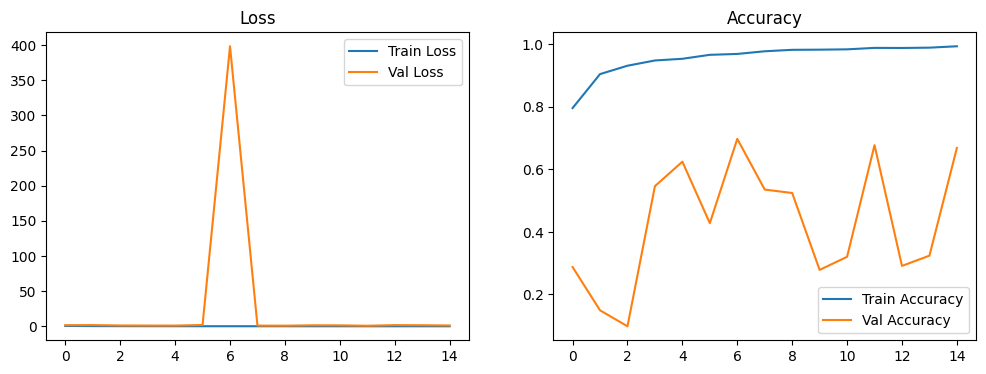

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluation on Test Data**

In [ ]:
# Evaluate on Test Data
model.load_weights('best_rop_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 912ms/step - accuracy: 0.4827 - auc: 0.6664 - loss: 1.0382 - precision: 0.5015 - recall: 0.3853
Test Loss: 0.7639
Test Accuracy: 0.7091
Test Precision: 0.7500
Test Recall: 0.6000
Test AUC: 0.8426


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 937ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.80      0.20      0.31        82
         ROP       0.72      0.94      0.82       190

    accuracy                           0.71       275
   macro avg       0.51      0.38      0.38       275
weighted avg       0.74      0.71      0.66       275


Confusion Matrix:
[[  0   0   3]
 [  0  16  66]
 [  7   4 179]]


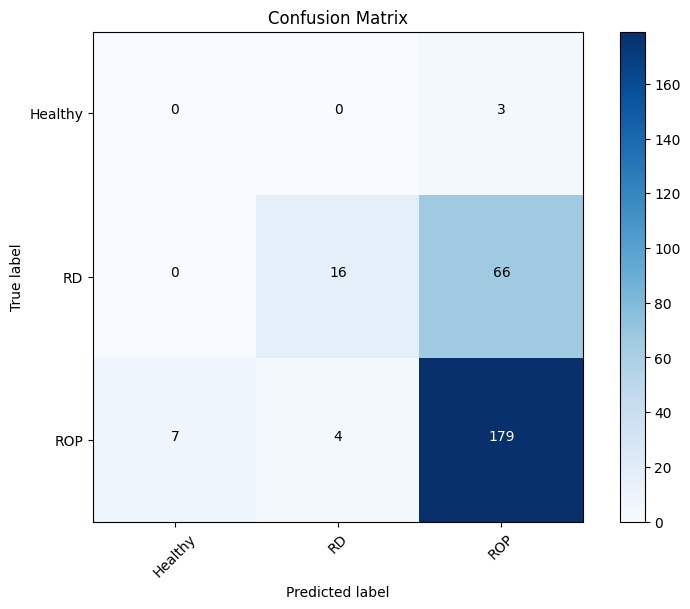

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnet_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/AIROP/robo_dataset/saved_models/efficientnet_rop_model.h5


# **Xception**

## **Import Libraries and Set Up Parameters**


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/content/drive/My Drive/AIROP/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build the Model**

In [ ]:
# Build the Model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for your number of classes
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Train the Model**

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_xception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7927 - auc: 0.9193 - loss: 0.5500 - precision: 0.8515 - recall: 0.6656
Epoch 1: val_loss improved from inf to 0.18449, saving model to best_xception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - accuracy: 0.7933 - auc: 0.9197 - loss: 0.5485 - precision: 0.8519 - recall: 0.6669 - val_accuracy: 0.9326 - val_auc: 0.9905 - val_loss: 0.1845 - val_precision: 0.9326 - val_recall: 0.9326
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9587 - auc: 0.9943 - loss: 0.1362 - precision: 0.9620 - recall: 0.9530
Epoch 2: val_loss improved from 0.18449 to 0.10075, saving model to best_xception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 92s 746ms/step - accuracy: 0.9587 - auc: 0.9943 - loss: 0.1361 - precision: 0.9620 - recall: 0.9530 - val_accuracy: 0.9690 - val_auc: 0.9951 - val_loss: 0.1007 - val_precision: 0.9690 - val_recall: 0.9690
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9744 - 

## **Plot Training History**

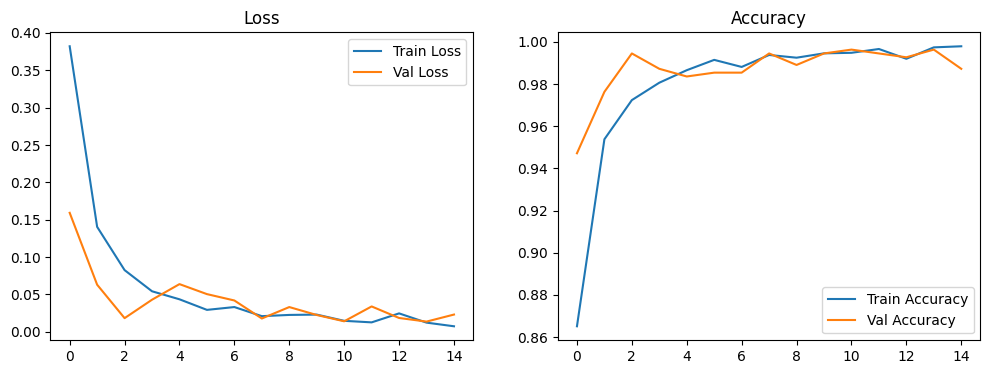

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model**

In [ ]:
# Evaluate the Model
model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0063 - precision: 1.0000 - recall: 1.0000
Test Loss: 0.0040
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test AUC: 1.0000


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
          RD       1.00      1.00      1.00        82
         ROP       1.00      1.00      1.00       190

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275


Confusion Matrix:
[[  3   0   0]
 [  0  82   0]
 [  0   0 190]]


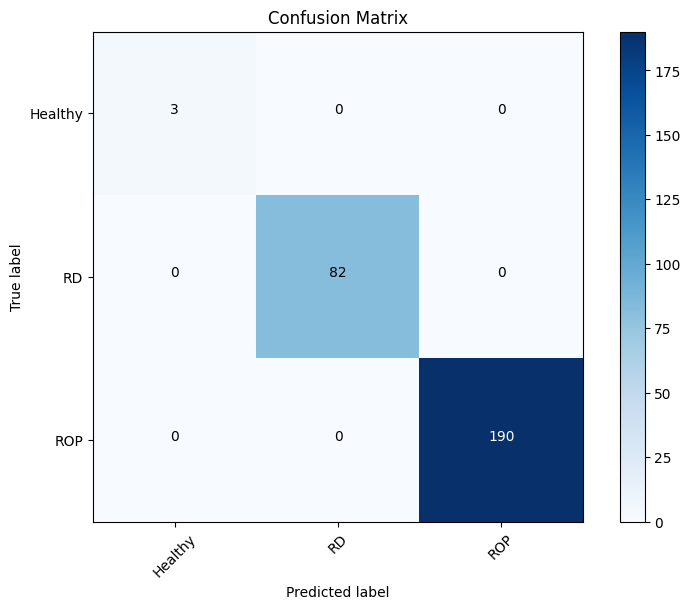

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [ ]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'xception_rop_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/AIROP/robo_dataset/saved_models/xception_rop_model.h5


# **InceptionV3**

## **Import Libraries and Set Up Parameters**


In [64]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [65]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Model**

In [66]:
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model with additional metrics
model.compile(
    optimizer="adam",  # or any optimizer of your choice
    loss="categorical_crossentropy",  # or any loss function suitable for your problem
    metrics=[
        "accuracy",  # default metric
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

# Display the model architecture
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

## **Train Model**

In [67]:
checkpoint = ModelCheckpoint(
    'best_inception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7745 - auc: 0.9084 - loss: 0.5992 - precision: 0.7831 - recall: 0.7645
Epoch 1: val_loss improved from inf to 0.26351, saving model to best_inception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 174s 778ms/step - accuracy: 0.7751 - auc: 0.9088 - loss: 0.5977 - precision: 0.7837 - recall: 0.7651 - val_accuracy: 0.9308 - val_auc: 0.9805 - val_loss: 0.2635 - val_precision: 0.9319 - val_recall: 0.9217
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9217 - auc: 0.9829 - loss: 0.2334 - precision: 0.9227 - recall: 0.9192
Epoch 2: val_loss improved from 0.26351 to 0.21233, saving model to best_inception_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 427ms/step - accuracy: 0.9217 - auc: 0.9829 - loss: 0.2334 - precision: 0.9227 - recall: 0.9192 - val_accuracy: 0.9454 - val_auc: 0.9868 - val_loss: 0.2123 - val_precision: 0.9452 - val_recall: 0.9417
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9561 - auc

## **Plotting Training History**

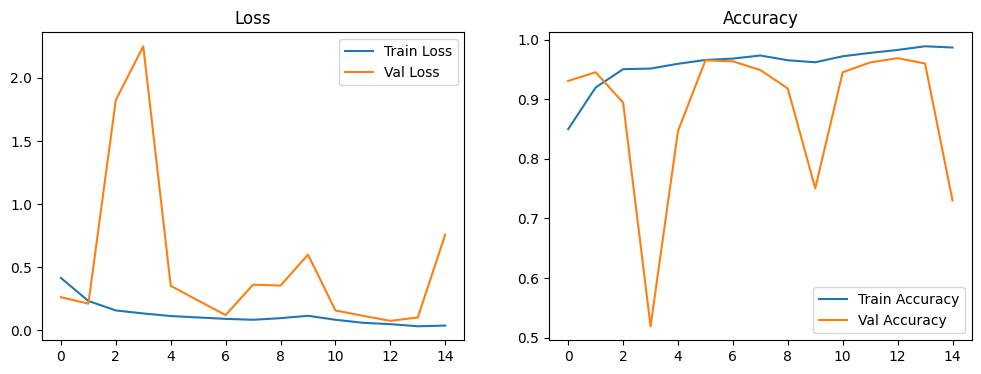

In [68]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test data**

In [69]:
model.load_weights('best_inception_model.keras')
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
# model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")



9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step - accuracy: 0.9509 - auc: 0.9825 - loss: 0.1626 - precision: 0.9509 - recall: 0.9509
Test Loss: 0.0722
Test Accuracy: 0.9782
Test Precision: 0.9782
Test Recall: 0.9782
Test AUC: 0.9937


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 614ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.33      0.50         3
          RD       1.00      0.95      0.97        82
         ROP       0.97      1.00      0.98       190

    accuracy                           0.98       275
   macro avg       0.99      0.76      0.82       275
weighted avg       0.98      0.98      0.98       275


Confusion Matrix:
[[  1   0   2]
 [  0  78   4]
 [  0   0 190]]


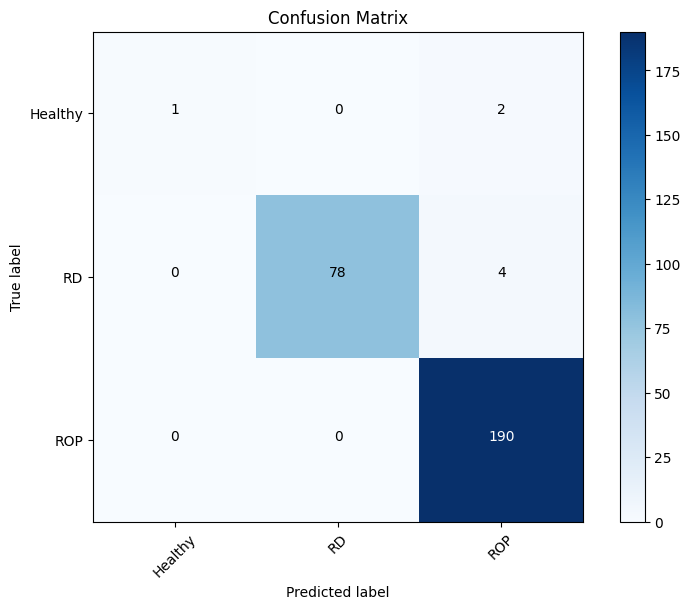

In [70]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [72]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'inceptionv3_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/inceptionv3_rop_model.h5


# **MobileNetV3**

## **Import Libraries and Set Up Parameters**



In [73]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV3Large
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [74]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Model**

In [75]:
mobilenetv3_base = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    mobilenetv3_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()




12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           2,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,974,835 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **Train the Model**

In [76]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_mobilenetv3_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7133 - auc: 0.8613 - loss: 0.6999 - precision: 0.7365 - recall: 0.6718
Epoch 1: val_loss improved from inf to 1.62352, saving model to best_mobilenetv3_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 131s 639ms/step - accuracy: 0.7142 - auc: 0.8619 - loss: 0.6980 - precision: 0.7373 - recall: 0.6729 - val_accuracy: 0.0091 - val_auc: 0.3552 - val_loss: 1.6235 - val_precision: 0.0091 - val_recall: 0.0091
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9252 - auc: 0.9863 - loss: 0.2154 - precision: 0.9293 - recall: 0.9222
Epoch 2: val_loss improved from 1.62352 to 1.40926, saving model to best_mobilenetv3_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 386ms/step - accuracy: 0.9252 - auc: 0.9863 - loss: 0.2153 - precision: 0.9293 - recall: 0.9222 - val_accuracy: 0.0091 - val_auc: 0.3603 - val_loss: 1.4093 - val_precision: 0.0092 - val_recall: 0.0091
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9549 -

## **Plotting Training History**

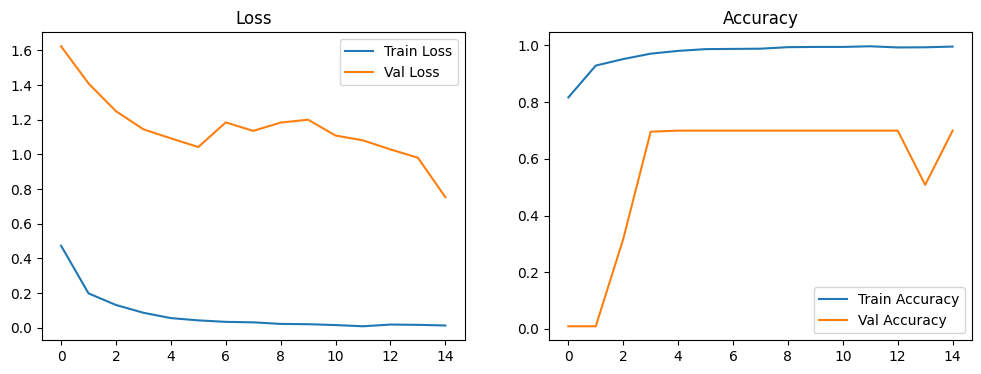

In [77]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test Data**

In [78]:
model.load_weights('best_mobilenetv3_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.4147 - auc: 0.6646 - loss: 1.1281 - precision: 0.4260 - recall: 0.3899
Test Loss: 0.7676
Test Accuracy: 0.6909
Test Precision: 0.7012
Test Recall: 0.6400
Test AUC: 0.8317
Mean Training Accuracy: 0.9718
Mean Validation Accuracy: 0.5689


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.69      1.00      0.82       190

    accuracy                           0.69       275
   macro avg       0.23      0.33      0.27       275
weighted avg       0.48      0.69      0.57       275


Confusion Matrix:
[[  0   0   3]
 [  1   0  81]
 [  0   0 190]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


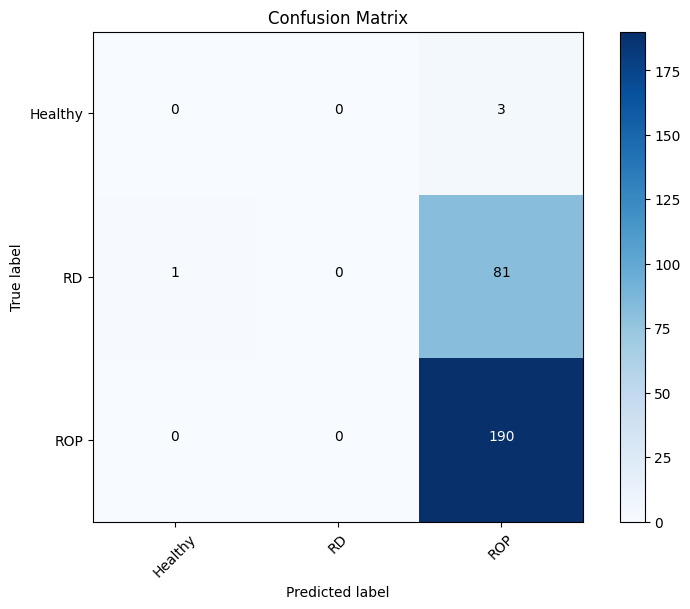

In [79]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [80]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'mobilenetv3_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/mobilenetv3_rop_model.h5


# **VGG16**


## **Import Libraries and Set Up parameters**

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build the Model**

In [3]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Add custom layers on top
model = Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer="adam",  # Can experiment with other optimizers like SGD
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 14,716,227 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**

In [4]:
checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6669 - auc: 0.8421 - loss: 1.4062 - precision: 0.6925 - recall: 0.6389
Epoch 1: val_loss improved from inf to 0.65351, saving model to best_vgg_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 95s 574ms/step - accuracy: 0.6671 - auc: 0.8422 - loss: 1.4017 - precision: 0.6925 - recall: 0.6393 - val_accuracy: 0.6995 - val_auc: 0.8574 - val_loss: 0.6535 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7181 - auc: 0.8539 - loss: 0.6642 - precision: 0.7176 - recall: 0.7160
Epoch 2: val_loss did not improve from 0.65351
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - accuracy: 0.7180 - auc: 0.8538 - loss: 0.6642 - precision: 0.7175 - recall: 0.7159 - val_accuracy: 0.6995 - val_auc: 0.8459 - val_loss: 0.6545 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7112 - auc: 0.8514 - loss: 0.6624 - precision: 0.7112 - recall: 0

## **Plotting training History**

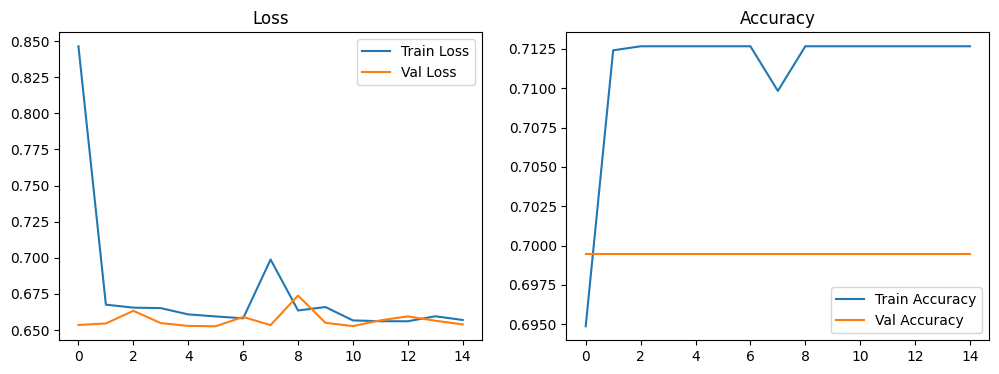

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate on Test Data**

In [6]:
model.load_weights('best_vgg_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - accuracy: 0.4147 - auc: 0.6935 - loss: 0.9743 - precision: 0.4147 - recall: 0.4147    
Test Loss: 0.6670
Test Accuracy: 0.6909
Test Precision: 0.6909
Test Recall: 0.6909
Test AUC: 0.8400
Mean Training Accuracy: 0.7113
Mean Validation Accuracy: 0.6995


## **Classification Report and Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.69      1.00      0.82       190

    accuracy                           0.69       275
   macro avg       0.23      0.33      0.27       275
weighted avg       0.48      0.69      0.56       275


Confusion Matrix:
[[  0   0   3]
 [  0   0  82]
 [  0   0 190]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


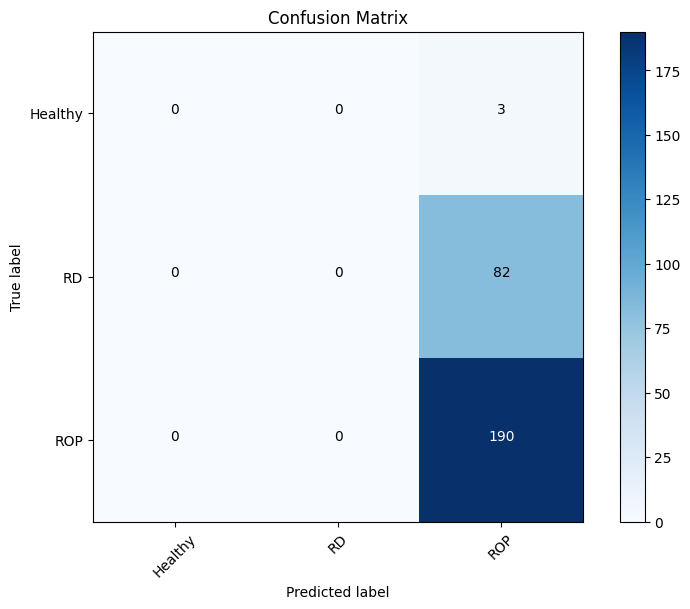

In [7]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [8]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'vgg16_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/vgg16_rop_model.h5


# **setting up dataset (not needed)**

In [ ]:
# Install and download dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CdeZJVrKXJQvsNCBSvks")
project = rf.workspace("airop").project("rop-vj9t0")
version = project.version(3)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ROP-3 in folder:: 100%|██████████| 4704/4704 [00:00<00:00, 8179.74it/s]


# **EfficientNetV2-L**

## **Import Libraries**

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2L
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Set Up Parameters**

In [16]:
# Dataset paths
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

In [17]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Build Function**

In [18]:
# Build and Compile the Model
# Load EfficientNetV2L as the backbone
regnet_base = EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    regnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,750,691 (449.18 MB)

 Trainable params: 117,238,115 (447.23 MB)

 Non-trainable params: 512,576 (1.96 MB)

## **Train Model**

In [19]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_efficientnetv2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8148 - auc: 0.9300 - loss: 0.4797 - precision: 0.8398 - recall: 0.7780
Epoch 1: val_loss improved from inf to 1.62833, saving model to best_efficientnetv2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.8152 - auc: 0.9302 - loss: 0.4788 - precision: 0.8401 - recall: 0.7786 - val_accuracy: 0.6995 - val_auc: 0.6779 - val_loss: 1.6283 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9056 - auc: 0.9797 - loss: 0.2563 - precision: 0.9079 - recall: 0.9040
Epoch 2: val_loss did not improve from 1.62833
122/122 ━━━━━━━━━━━━━━━━━━━━ 89s 705ms/step - accuracy: 0.9056 - auc: 0.9797 - loss: 0.2562 - precision: 0.9080 - recall: 0.9041 - val_accuracy: 0.6995 - val_auc: 0.7746 - val_loss: 2.3239 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9349 - auc: 0.9864 - loss: 0.2055 - precision: 0

## **Plot Training History**

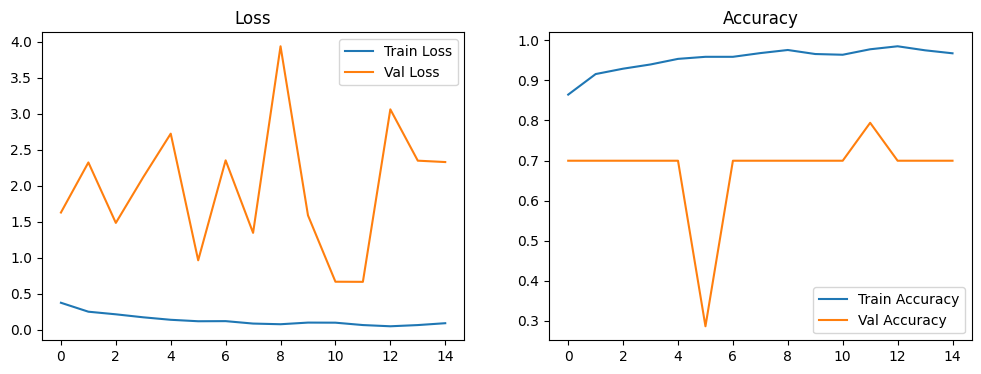

In [24]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate the Model on Test Data**

In [31]:
# Evaluate the Model on Test Data
model.load_weights('best_efficientnetv2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.6196 - auc: 0.7623 - loss: 1.4260 - precision: 0.6183 - recall: 0.6089
Test Loss: 0.7079
Test Accuracy: 0.8036
Test Precision: 0.8051
Test Recall: 0.7964
Test AUC: 0.9239
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.40      0.67      0.50         3
          RD       1.00      0.37      0.54        82
         ROP       0.79      0.99      0.88       190

    accuracy                           0.80       275
   macro avg       0.73      0.68      0.64       275
weighted avg       0.85      0.80      0.77       275



## **Confusion Matrix**


Confusion Matrix:
[[  2   0   1]
 [  2  30  50]
 [  1   0 189]]


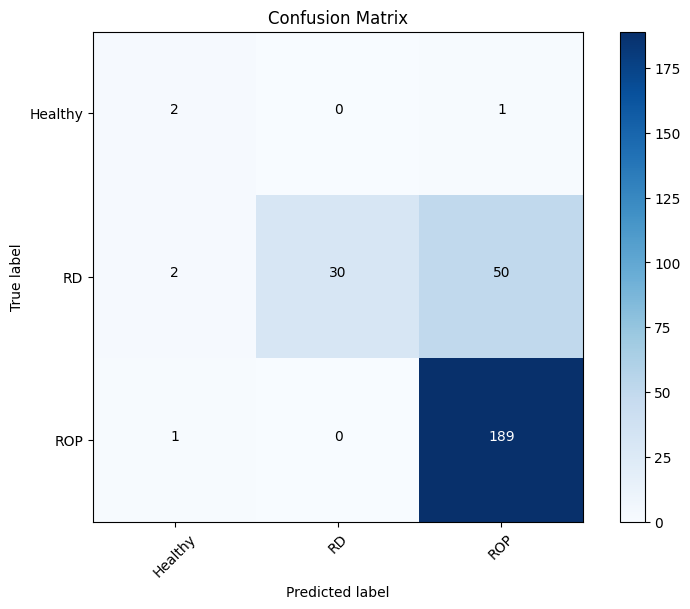

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [35]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'efficientnetv2_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/efficientnetv2_rop_model.h5


# **ResNet50V2**

## **Import Libraries**

In [43]:
# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [44]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

In [45]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Function for Building Model**

In [46]:
# Build and Compile the Model
# Load ResNe50V2
resnext_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    resnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,570,947 (89.92 MB)

 Trainable params: 23,525,507 (89.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

## **Train Model**

In [47]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_resnet50v2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7832 - auc: 0.9160 - loss: 0.5572 - precision: 0.7924 - recall: 0.7704
Epoch 1: val_loss improved from inf to 0.65922, saving model to best_resnet50v2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 130s 635ms/step - accuracy: 0.7837 - auc: 0.9162 - loss: 0.5561 - precision: 0.7928 - recall: 0.7709 - val_accuracy: 0.8142 - val_auc: 0.9473 - val_loss: 0.6592 - val_precision: 0.8142 - val_recall: 0.8142
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9122 - auc: 0.9785 - loss: 0.2639 - precision: 0.9148 - recall: 0.9102
Epoch 2: val_loss improved from 0.65922 to 0.48224, saving model to best_resnet50v2_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.9122 - auc: 0.9785 - loss: 0.2640 - precision: 0.9148 - recall: 0.9102 - val_accuracy: 0.9199 - val_auc: 0.9644 - val_loss: 0.4822 - val_precision: 0.9199 - val_recall: 0.9199
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy:

## **Plot Training History**

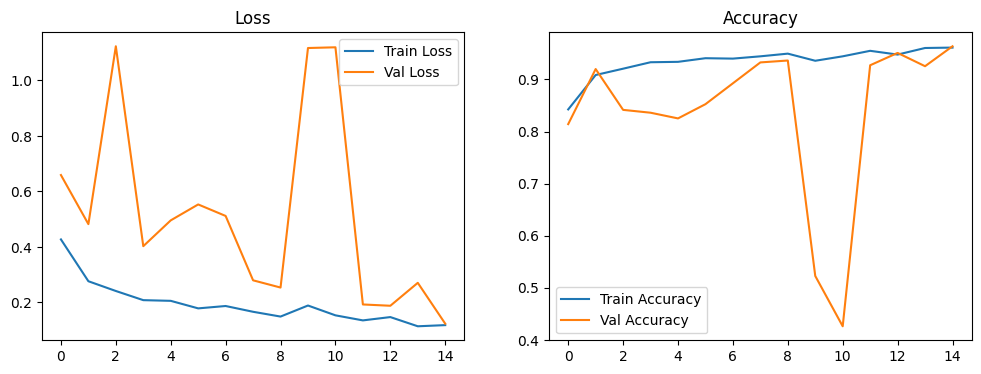

In [48]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [49]:
# Evaluate the Model on Test Data
model.load_weights('best_resnet50v2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step - accuracy: 0.9137 - auc: 0.9836 - loss: 0.2402 - precision: 0.9193 - recall: 0.9137
Test Loss: 0.1371
Test Accuracy: 0.9527
Test Precision: 0.9562
Test Recall: 0.9527
Test AUC: 0.9936
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.33      0.33      0.33         3
          RD       0.96      0.91      0.94        82
         ROP       0.96      0.98      0.97       190

    accuracy                           0.95       275
   macro avg       0.75      0.74      0.75       275
weighted avg       0.95      0.95      0.95       275



## **Confusion Matrix**


Confusion Matrix:
[[  1   0   2]
 [  1  75   6]
 [  1   3 186]]


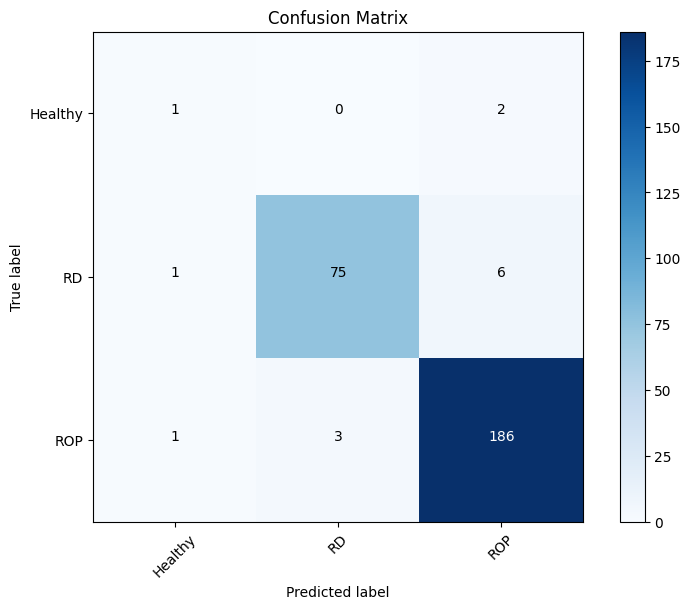

In [50]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [52]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'resnet50v2_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/resnet50v2_rop_model.h5


# **ConvNeXt**

## **Import Libraries and Set Random Seeds**

In [53]:

# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtBase  # ConvNeXt model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [54]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset/robo_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

In [55]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3877 images belonging to 3 classes.
Found 549 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


## **Function for Building Models**

In [56]:
# Build and Compile the Model
# Load ConvNeXt model
convnext_base = ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    convnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,569,539 (334.05 MB)

 Trainable params: 87,569,539 (334.05 MB)

 Non-trainable params: 0 (0.00 B)

## **Train ConvNeXt**

In [57]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_convnext_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.6040 - auc: 0.7775 - loss: 1.2842 - precision: 0.6082 - recall: 0.5969
Epoch 1: val_loss improved from inf to 0.66162, saving model to best_convnext_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.6043 - auc: 0.7778 - loss: 1.2813 - precision: 0.6084 - recall: 0.5972 - val_accuracy: 0.6995 - val_auc: 0.8452 - val_loss: 0.6616 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6976 - auc: 0.8526 - loss: 0.6852 - precision: 0.6998 - recall: 0.6922
Epoch 2: val_loss improved from 0.66162 to 0.65670, saving model to best_convnext_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 92s 723ms/step - accuracy: 0.6975 - auc: 0.8525 - loss: 0.6852 - precision: 0.6997 - recall: 0.6921 - val_accuracy: 0.6995 - val_auc: 0.8452 - val_loss: 0.6567 - val_precision: 0.6995 - val_recall: 0.6995
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6817 - auc: 0.8

## **Plot Training History**

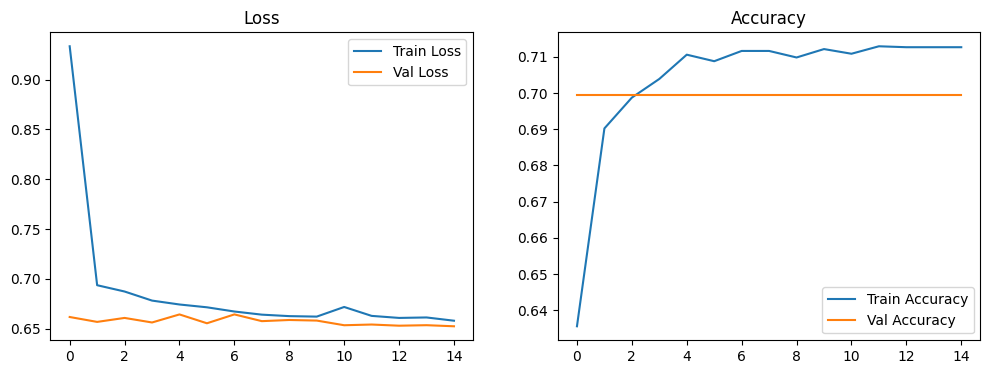

In [58]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Generate Reports And Visualizations**

In [59]:
# Evaluate the Model on Test Data
model.load_weights('best_convnext_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.4147 - auc: 0.6935 - loss: 0.9602 - precision: 0.4147 - recall: 0.4147     
Test Loss: 0.6660
Test Accuracy: 0.6909
Test Precision: 0.6909
Test Recall: 0.6909
Test AUC: 0.8400
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 707ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        82
         ROP       0.69      1.00      0.82       190

    accuracy                           0.69       275
   macro avg       0.23      0.33      0.27       275
weighted avg       0.48      0.69      0.56       275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[  0   0   3]
 [  0   0  82]
 [  0   0 190]]


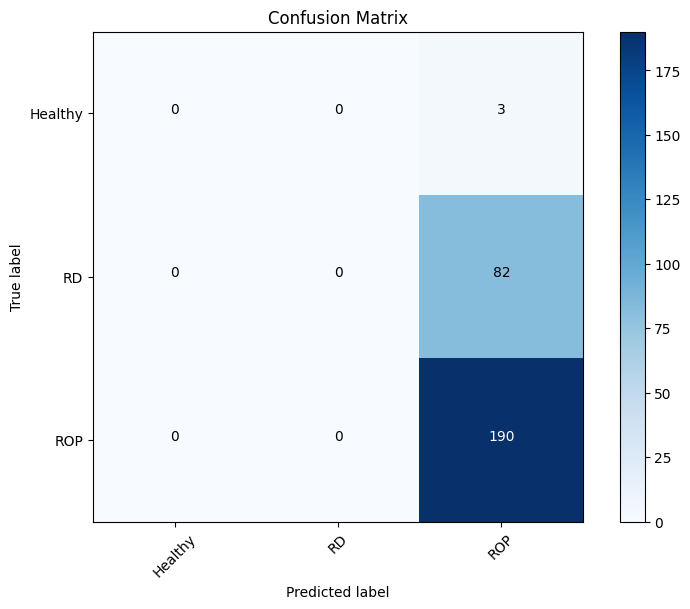

In [60]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## **Save the Model**

In [63]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'convnext_rop_model.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/convnext_rop_model.h5
